# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission, if necessary. Sections that begin with **'Implementation'** in the header indicate where you should begin your implementation for your project. Note that some sections of implementation are optional, and will be marked with **'Optional'** in the header.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

## Summary

In this notebook, I've implemented a 'VGG lite' style architecture for classifying German Road Traffic Signs. With this simple architecture, the network achieves a **98.15% accuracy** result on the Test dataset. 

**Briefly, What Worked:**

- **Learning Rate Schedule:** Reducing the learning rate automatically helped. The LR was set to 0.01, and reduced automatically using the Stochastic Gradient Descent class. Additionally, Keras allows `ReduceLROnPlateau` callback that automatically further reduces LR based on specified params. 
- **Dropout:** Dropouts were used - varying from 30% to 50% after Maxpool and Dense layers. This helped greatly.

- **Fully Connected Layers:** Increasing the size of fully connected layers (from, say, 400 to 1024 neurons) as well as the number (from 1-2 to 3 FC layers) greatly increased the performance (while increasing the training time, of course).

**What Didn't Work:**

- ** L2 Regularization:** I tried L2 regularization with a few values; however, the effect of L2 wasn't meaningful for this architecture, hence it was left out for training.

**NOTE**. I used **Keras** framework (on top of TensorFlow) for this as I already have experience with TensorFlow library, and wanted to test out different architectures quickly.

The final model architecture is as shown:

![Model Architecture](AA-CNN-model-traffic-signs.jpg)

In [1]:
import numpy as np
import tensorflow as tf
import pandas as pd
import cv2
import time as time
from sklearn.preprocessing import OneHotEncoder
from sklearn.cross_validation import train_test_split
from sklearn.metrics import confusion_matrix

import os
from PIL import Image
import time

import matplotlib.pyplot as plt

%matplotlib inline


import keras
from keras import backend as K
from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.metrics import top_k_categorical_accuracy
from keras.regularizers import l2, activity_l2
from keras.models import model_from_yaml
from keras.models import model_from_json

from keras.models import Sequential
from keras.layers import Convolution2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense

# set 'Tensorflow' image ordering: [Batch, Height, Width, Channels]
K.set_image_dim_ordering('tf')
print('Keras version:', keras.__version__)

/Users/aa/Developer/miniconda/envs/py35/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


Keras version: 1.2.0


Using TensorFlow backend.


In [2]:
# watermark the libs used
%load_ext watermark

%watermark -a 'Atul Acharya' -u -d -v -p numpy,pandas,tensorflow,matplotlib,cv2,keras

Atul Acharya 
last updated: 2017-01-21 

CPython 3.5.2
IPython 5.0.0

numpy 1.11.3
pandas 0.18.1
tensorflow 0.11.0rc2
matplotlib 1.5.1
cv2 3.1.0
keras 1.2.0


---
## Step 0: Load The Data

In [3]:
# Load pickled data
import pickle

# TODO: Fill this in based on where you saved the training and testing data
DATA_DIR = 'traffic-signs-data'

training_file = DATA_DIR + '/train.p'
testing_file =  DATA_DIR + '/test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_test,  y_test  = test['features'],  test['labels']

print('Train set shape:{0}'.format(X_train.shape))
print('Test  set shape:{0}'.format(X_test.shape))

print('Train labels: {0}'.format(y_train.shape))
print('Test  labels: {0}'.format(y_test.shape))

Train set shape:(39209, 32, 32, 3)
Test  set shape:(12630, 32, 32, 3)
Train labels: (39209,)
Test  labels: (12630,)


---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 2D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

Complete the basic data summary below.

In [4]:
### Replace each question mark with the appropriate value.

# TODO: Number of training examples
n_train = len(X_train)

# TODO: Number of testing examples.
n_test = len(X_test)

# TODO: What's the shape of an traffic sign image?
image_shape = np.shape(X_train[5])

# TODO: How many unique classes/labels there are in the dataset.
n_classes = len(np.unique(y_train))

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 39209
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


In [5]:
# One-hot encode the labels
y_labels_train = np_utils.to_categorical(y_train, n_classes)
y_labels_test  = np_utils.to_categorical(y_test,  n_classes)
print('train labels: ', y_labels_train.shape)
print('test  labels: ', y_labels_test.shape)

train labels:  (39209, 43)
test  labels:  (12630, 43)


Visualize the German Traffic Signs Dataset using the pickled file(s). This is open ended, suggestions include: plotting traffic sign images, plotting the count of each sign, etc.

The [Matplotlib](http://matplotlib.org/) [examples](http://matplotlib.org/examples/index.html) and [gallery](http://matplotlib.org/gallery.html) pages are a great resource for doing visualizations in Python.

**NOTE:** It's recommended you start with something simple first. If you wish to do more, come back to it after you've completed the rest of the sections.

In [6]:
### Data exploration visualization goes here.
### Feel free to use as many code cells as needed.
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.gridspec as gridspec
# Visualizations will be shown in the notebook.
%matplotlib inline

In [7]:
def plot_signs(ncols, nrows, X, y):
    plt.figure(figsize = (10,8))
    gs1 = gridspec.GridSpec(ncols,nrows)
    gs1.update(wspace=0.01, hspace=0.01) # set the spacing between axes.

    for i in range(nrows*ncols):
        # i = i + 1 # grid spec indexes from 0
        ax1 = plt.subplot(gs1[i])
        #plt.axis('on')

        ax1.set_aspect('equal')
        rand_ix = np.random.randint(1,len(y))
        plt.imshow(X[rand_ix])
        plt.text(25,4,str(y[rand_ix]), color='k',backgroundcolor='y')
        plt.axis('off')
    plt.show()


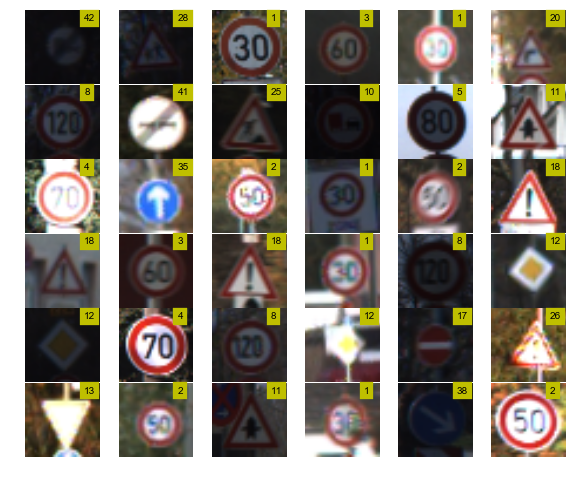

In [8]:
plot_signs(6,6, X_train, y_train)

### Explore Sign Names

Let's find out the sign names, types and their distribution in the dataset.

In [9]:
# Let's find what the sign names are
sign_names = pd.read_csv('signnames.csv')
sign_names.head()

,ClassId,SignName
0,0,Speed limit (20km/h)
1,1,Speed limit (30km/h)
2,2,Speed limit (50km/h)
3,3,Speed limit (60km/h)
4,4,Speed limit (70km/h)


Let's find out how many observations in each class for Train and Test datasets

In [10]:
## How many observations in each sign name (class type)?

## 1. Train Dataset
train_label_freq = [[i, sum(y_train == i)] for i in range(n_classes)]
train_label_freq = sorted(train_label_freq, key=lambda x: x[0])
#label_freq

sign_names['train_frequency'] = pd.Series(np.asarray(train_label_freq).T[1], 
                                          index=np.asarray(train_label_freq).T[0])


## 2. Test dataset
test_label_freq = [[i, sum(y_test == i)] for i in range(n_classes)]
test_label_freq = sorted(test_label_freq, key=lambda x: x[0])

sign_names['test_frequency'] = pd.Series(np.asarray(test_label_freq).T[1], 
                                         index=np.asarray(test_label_freq).T[0])

In [11]:
sign_names.head()


,ClassId,SignName,train_frequency,test_frequency
0,0,Speed limit (20km/h),210,60
1,1,Speed limit (30km/h),2220,720
2,2,Speed limit (50km/h),2250,750
3,3,Speed limit (60km/h),1410,450
4,4,Speed limit (70km/h),1980,660


In [12]:
# Let's plot the frequency of sign-names

def plot_label_frequency(sign_names, prefix=''):
    plt.figure(1, figsize=(15,15))
    plt.barh(sign_names['ClassId'], sign_names['train_frequency'], height=0.8)
    plt.barh(sign_names['ClassId'], sign_names['test_frequency'], color='red', height=0.6)
    plt.yticks(sign_names['ClassId'], sign_names['SignName'])
    plt.title(prefix + 'Frequency of Traffic Signs')
    plt.legend(['Train freq', 'Test freq'], loc='upper right')
    plt.xlabel('Count')
    plt.ylabel('Sign Name')
    plt.show()

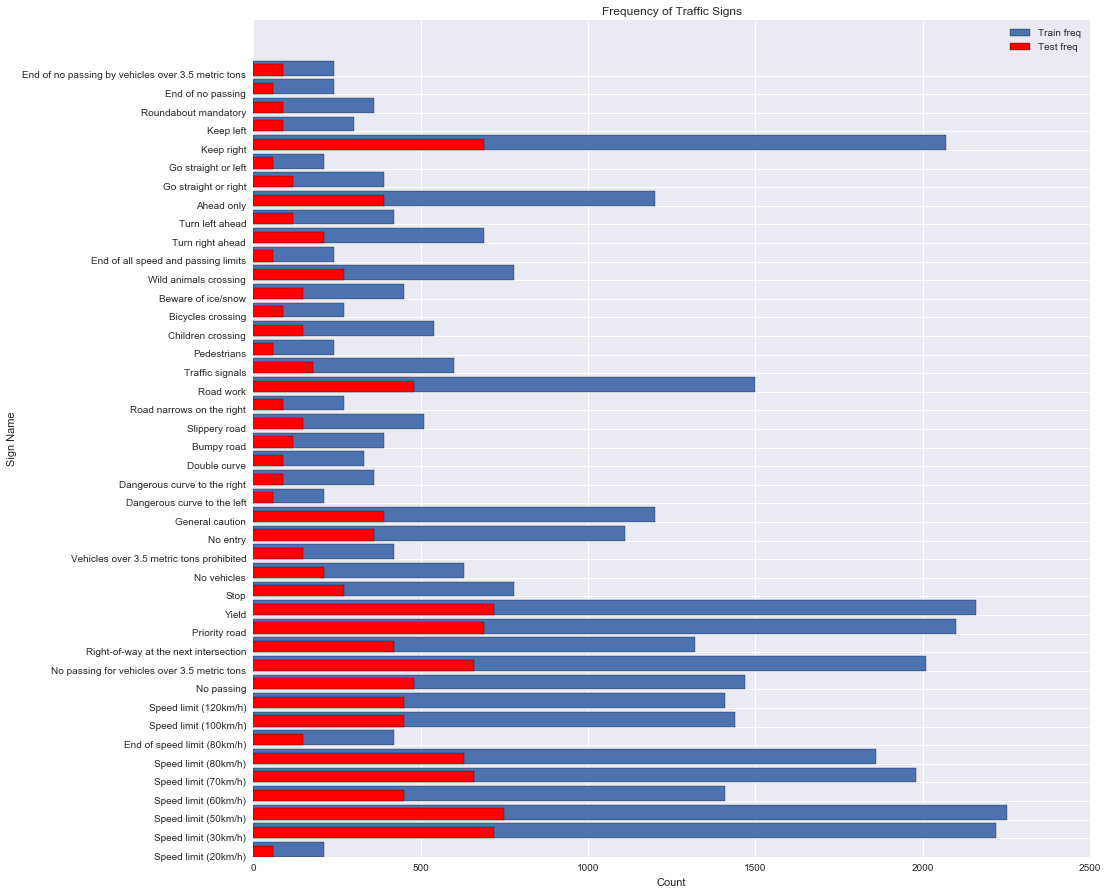

In [13]:
plot_label_frequency(sign_names)

#### Notes: 

We see that the _distribution of signs varies quite a lot_; some classes have ~2000 images, while others have 1/10th (~200 images) only. This can be troubling. But this is the real world. We have to deal with this. We will **augment our dataset** shortly.

In [14]:
# See what's image data -- the max, min, etc.

xmax = np.max(X_train)
xmin = np.min(X_train)
xstddev = np.std(X_train)
xmean = np.mean(X_train)

print('Train set: max {0}, min {1}, mean {2}, stddev {3}'.format(xmax, xmin, xmean, xstddev))

Train set: max 255, min 0, mean 82.66505234601485, stddev 69.04017850309661


In [15]:
print('Test set: max {0}, min {1}, mean {2}, stddev {3}'.format(np.max(X_test), 
                                                                np.min(X_test), 
                                                                np.mean(X_test), 
                                                                np.std(X_test)))

Test set: max 255, min 0, mean 82.14846036120183, stddev 68.74408941423404


## Image Normalization (Question 1)

We will normalize the images to ensure that our training images are standardized; this will remove the effects of effects such as too much/too little brightness, color saturation, etc.

After testing a couple of techniques, I settled on **equalizing histograms** for normalizing the images. 

In [16]:
def normalize_image(image):
    '''  Normalizes given image, after copying it first, using MINMAX, so that result is between [0,1]
    '''
    dst = np.copy(image)
    norm_image = cv2.normalize(image, dst, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
    return norm_image


In [17]:
# Let's pre process an image
def normalize_min_max_image(image):
    ''' Normalize 
    '''
    xmin = np.min(image)
    xmax = np.max(image)
    a, b = 0.1, 0.9
    scaled_img = a + (image - xmin) * (b - a) / (xmax - xmin)

    return scaled_img

In [18]:
# Equalization functions
def eq_histogram_rescale(image):
    ''' Equalize histogram (for each channel), then rescale to 1/255
    '''
    image[:,:,0] = cv2.equalizeHist(image[:,:,0])
    image[:,:,1] = cv2.equalizeHist(image[:,:,1])
    image[:,:,2] = cv2.equalizeHist(image[:,:,2])
    image = image / 255.
    return image

def mean_subtract(img):
    ''' Remove mean (feature-wise)
    '''
    #img  = img / 255.
    img -= np.mean(img, axis=0)
    return img

def equalize_and_mean_subtract(image):
    ''' Equalize histograms, and then remove mean.
    '''
    # 1st equalise histo
    img_eh = eq_histogram_rescale(image)
    # then subtract mean
    return mean_subtract(img_eh)


#### Histogram Equalization

We chose the histogram equalization as this gives the best performance. By doing this, we are removing the effects of brightness, etc. so that images are easier to train.

In [19]:
## Pre-process the train / test data -- equalize Histogram
# Use this for Model Fitting..
X_train_proc = np.array([eq_histogram_rescale(X_train[i]) for i in range(len(X_train))], dtype=np.float32)
X_test_proc  = np.array([eq_histogram_rescale(X_test[i]) for i in range(len(X_test))], dtype=np.float32)

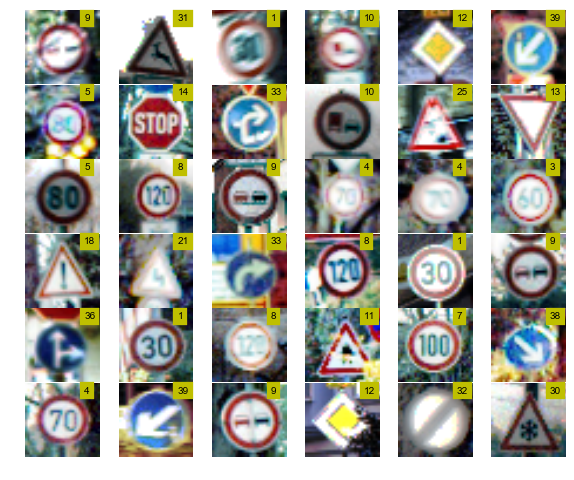

In [20]:
## Plot the normalized training dataset
plot_signs(6, 6, X_train_proc, y_train)

## Train / Validation Split (Question 2)

Now let's split the Training dataset into 80% Trainign and 20% Validation set. We will use the validation set to refine our models; then use the refined model for final testing on the actual Test dataset

In [21]:
## Split Train-Validation datas

from sklearn.model_selection import train_test_split

np.random.seed(123)

X_train, X_validation, y_train, y_validation = train_test_split(X_train_proc,
                                                               y_train,
                                                               random_state=0,
                                                               test_size=0.2)
print('Training shape:{0}'.format(X_train.shape))
print('Validatn shape:{0}'.format(X_validation.shape))
print('Testing  shape:{0}'.format(X_test_proc.shape))

print('Train   labels:{0}'.format(y_train.shape))
print('Valid.  labels:{0}'.format(y_validation.shape))
print('Test    labels:{0}'.format(y_test.shape))

Training shape:(31367, 32, 32, 3)
Validatn shape:(7842, 32, 32, 3)
Testing  shape:(12630, 32, 32, 3)
Train   labels:(31367,)
Valid.  labels:(7842,)
Test    labels:(12630,)


In [22]:
## One-hot encode Labels
y_train_ohe      = np_utils.to_categorical(y_train, n_classes)
y_validation_ohe = np_utils.to_categorical(y_validation, n_classes)
y_test_ohe       = np_utils.to_categorical(y_test,  n_classes)
print('train labels: ', y_train_ohe.shape)
print('valid labels: ', y_validation_ohe.shape)
print('test  labels: ', y_test_ohe.shape)

train labels:  (31367, 43)
valid labels:  (7842, 43)
test  labels:  (12630, 43)


## Image Augmentation (Question 1)

We will try the Image Augmenation/Pre-Processing module from Keras that augments images based on specified directives.

**Keras** framework was used because:

- it provides easy-to-use Image Pre-Processing API via **ImageDataGenerator**
- it offers plenty of choice for augmenting: shearing, rotation, height/width shift, rescaling, feature-wise centering and mean subtraction, among others
- see details at Keras Preprocessing [https://keras.io/preprocessing/image/]

In practice though, since we had already rescaled the images, we used only rotation, shearing, height/width shifts for augmenting the data. 

In [23]:
# Create an Image Data Generator - for testing

train_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    fill_mode='nearest')

train_datagen.fit(X_train_proc)



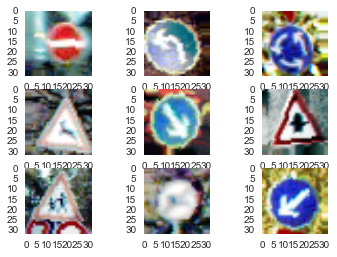

In [24]:
# show a 3x3 grid of augmented image data
for X_batch, y_batch in train_datagen.flow(X_train, y_train, batch_size=36):
    # 3x3 grid
    for i in range(0,9):
        plt.subplot(330 + 1 + i)
        plt.grid('off')
        plt.imshow(X_batch[i])
    plt.show()
    break

We can see how the images are sheared, rotated, or shifted; this will enable us to better detect images in the real world. 

## Testing Model Architectures (Question 3, 4, 5)

We tested with a few CNN model architectures. Some of them are shown below.

We used Keras [http://keras.io] as a higher-level API on TensorFlow as the API is easier to use than regular TensorFlow, for defining and testing out models quickly. 

In [25]:
INPUT_SHAPE = (32, 32, 3) # Height x Width x Channels   (in TF style dim ordering)

In [26]:
# other Keras imports
from keras.optimizers import SGD
from keras.callbacks import ModelCheckpoint

In [27]:
def create_lenet_model():
    ''' Creates and returns a LeNet model with deeper filters and denser FC layers
    '''
    print('Creating LeNet model...')
    model = Sequential()
    
    # L0 - 16 filters of 5x5, stride 1; followed by maxpool 2x2
    model.add(Convolution2D(16, 5, 5, 
                            input_shape=INPUT_SHAPE, 
                            activation='relu', 
                            border_mode='valid', 
                            name='conv0'))
    model.add(MaxPooling2D(pool_size=(2, 2), border_mode='valid', name='maxpool0'))
    model.add(Dropout(0.3))
    
    # L1 - 32 filters of 5x5, stride 1; followed by maxpool 2x2
    model.add(Convolution2D(32, 5, 5, 
                            activation='relu', 
                            border_mode='valid', 
                            name='conv1'))
    model.add(MaxPooling2D(pool_size=(2, 2), border_mode='valid', name='maxpool1'))
    model.add(Dropout(0.3))

    model.add(Flatten())

    # FC layers
    model.add(Dense(1024, activation='relu', name='fc0'))
    model.add(Dropout(0.5))
    model.add(Dense(512, activation='relu', name='fc1'))
    model.add(Dropout(0.5))
    model.add(Dense(128, activation='relu', name='fc2'))

    # final layer: 43 output classes
    model.add(Dense(n_classes, activation='softmax', name='fc_last'))

    print(model.summary())
    return model


In [28]:
def create_vgg_lite():
    '''  Create a lite VGG model
    '''
    print('Creating VGG-lite1 model...')
    model = Sequential()
    
    # L1
    model.add(Convolution2D(16, 3, 3, 
                            activation='relu', 
                            border_mode='valid', 
                            input_shape=INPUT_SHAPE, name='conv0'))
    model.add(Convolution2D(16, 3, 3, 
                            activation='relu', 
                            border_mode='valid', name='conv1'))
    model.add(MaxPooling2D(pool_size=(2, 2), 
                           border_mode='valid'))
    model.add(Dropout(0.3))
    
    # L2
    model.add(Convolution2D(32, 5, 5, 
                            activation='relu', 
                            border_mode='valid', name='conv2'))
    model.add(Convolution2D(32, 5, 5, 
                            activation='relu', 
                            border_mode='valid', name='conv3'))
    model.add(MaxPooling2D(pool_size=(2, 2), border_mode='valid'))
    model.add(Dropout(0.3))

    model.add(Flatten())

    # FC layers
    model.add(Dense(1024, activation='relu', name='fc0'))
    model.add(Dropout(0.5))
    model.add(Dense(512, activation='relu', name='fc1'))
    model.add(Dropout(0.5))
    model.add(Dense(256, activation='relu', name='fc2'))

    # final layer: 43 Output classes
    model.add(Dense(n_classes, activation='softmax', name='fc_last'))

    print(model.summary())
    return model


In [29]:
def baseline_model():
    ''' Create and return a very simple baseline model: 2 conv layers with 2 maxpools, 
        and two lean FC layers
    '''
    print('Creating baseline model')
    model = Sequential()
    model.add(Convolution2D(30, 5, 5, 
                            input_shape=INPUT_SHAPE, 
                            activation='relu' ))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Convolution2D(15, 3, 3, 
                            activation='relu' ))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))
    
    model.add(Flatten())
    model.add(Dense(128, activation='relu' ))
    model.add(Dense(50, activation='relu' ))
    
    model.add(Dense(n_classes, activation='softmax' ))
    return model

In [30]:
## Plot History of Training / Validation

def plot_history(history, name='model'):
     # plot history
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title(name + ' model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

    # plot loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title(name + ' model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()


In [31]:
### Run the model

def run_model_augmentation(model, name='model', weights=None, nb_epochs=10):
    ''' Run model, while augmenting training / validation data '''

    print('** Augmenting Training data...')
    # 1. Augment training data
    train_datagen = ImageDataGenerator(
            rotation_range=15,
            width_shift_range=0.1,
            height_shift_range=0.1,
            shear_range=0.1,
            fill_mode='nearest')

    train_datagen.fit(X_train)

    # 2. Augment validation data
    print('** Augmenting Validation data...')
    validation_datagen = ImageDataGenerator(
            rotation_range=15,
            width_shift_range=0.1,
            height_shift_range=0.1,
            shear_range=0.1,
            fill_mode='nearest')

    validation_datagen.fit(X_validation)

    # 3. Prepare for training - Load saved weights, if needed
    print()
    print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')
    print()

    from keras.callbacks import ReduceLROnPlateau

    now = time.localtime()

    # 3a. Define Optimizing params
    learning_rate = 0.01
    decay_rate = learning_rate / nb_epochs
    sgd = SGD(lr=learning_rate, decay=1e-6, momentum=0.9, nesterov=True)

    # 3b. If earlier model saved, use it
    if weights is not None:
        # ''' load saved weights'''
        print('Loading saved weights: ', weights)
        model.load_weights(weights)

    # 3c. Compile the model
    model.compile(loss='categorical_crossentropy', 
                        optimizer=sgd,
                        metrics=['accuracy', 'top_k_categorical_accuracy'])

    # 3d. Training params
    BATCH_SIZE = 64
    NB_EPOCHS  = nb_epochs

    ## 3e. Checkpoints: save model while training 
    filepath= name + '_' + str(now.tm_mday) + '_' + str(now.tm_hour) + '_' + str(now.tm_min) \
            + "_weights-{epoch:02d}-{val_acc:.2f}.hdf5"
    checkpoint = ModelCheckpoint(filepath, 
                                 monitor='val_acc', 
                                 verbose=1, 
                                 save_best_only=True, 
                                 mode= max )
    # 3f. reduce LR on schedule
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, verbose=1)

    # 3g. Define callsbacks
    callbacks_list = [checkpoint, reduce_lr]

    ## 4. Start Training/Fit
    print('Starting training...')
    history = model.fit_generator(
            train_datagen.flow(X_train, y_train_ohe, batch_size=BATCH_SIZE),
            samples_per_epoch=X_train.shape[0],
            nb_epoch=NB_EPOCHS,
            validation_data=validation_datagen.flow(X_validation, 
                                                    y_validation_ohe,
                                                    batch_size=BATCH_SIZE),
            nb_val_samples=len(X_validation),
            callbacks=callbacks_list,
            verbose=2)

    ## 5. Test on test data
    print()
    print('Doing eval on TEST...')
    score = model.evaluate(X_test_proc, y_test_ohe, verbose=1)
    print()
    print('Metrics are: ', model.metrics_names)
    print('Test scores: ', score)
    for m in range(len(score)):
        print(' Metric: %s ==> "%0.5f" ' % (model.metrics_names[m], score[m]))

    #plot_history(history, name)
    return history


In [32]:
def save_load_model(model, name='model', weights=None):
    ''' Save the given model ''' 
    print('Saving model: ', name)

    model_yaml = model.to_yaml()
    with open(name + '.yaml', 'w') as yaml_file:
        yaml_file.write(model_yaml)

    if weights is not None:
        ''' load saved weights'''
        print('Loading saved weights: ', weights)
        model.load_weights(weights)
        print('model weights loaded')

    # compile model
    print('compiling model...')
    model.compile(loss='categorical_crossentropy', 
                        optimizer='adam',
                        metrics=['accuracy', 'top_k_categorical_accuracy'])


    print('saving weights: ', name + '.hdf5')
    model.save_weights(name + '.hdf5')


In [33]:
## Create a VGG-lite model

vgg_lite1 = create_vgg_lite()


Creating VGG-lite1 model...
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
conv0 (Convolution2D)            (None, 30, 30, 16)    448         convolution2d_input_1[0][0]      
____________________________________________________________________________________________________
conv1 (Convolution2D)            (None, 28, 28, 16)    2320        conv0[0][0]                      
____________________________________________________________________________________________________
maxpooling2d_1 (MaxPooling2D)    (None, 14, 14, 16)    0           conv1[0][0]                      
____________________________________________________________________________________________________
dropout_1 (Dropout)              (None, 14, 14, 16)    0           maxpooling2d_1[0][0]             
_______________________________________________________________

In [34]:
# run the VGG_lite model
history = run_model_augmentation(vgg_lite1, name='VGG_lite1', nb_epochs=30)

** Augmenting Training data...
** Augmenting Validation data...

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Starting training...


/Users/aa/Developer/miniconda/envs/py35/lib/python3.5/site-packages/keras/callbacks.py:267: RuntimeWarning: ModelCheckpoint mode <built-in function max> is unknown, fallback to auto mode.
  RuntimeWarning)


Epoch 1/30
Epoch 00000: val_acc improved from -inf to 0.06924, saving model to VGG_lite1_19_23_59_weights-00-0.07.hdf5
56s - loss: 3.5214 - acc: 0.0545 - top_k_categorical_accuracy: 0.2705 - val_loss: 3.4726 - val_acc: 0.0692 - val_top_k_categorical_accuracy: 0.3072
Epoch 2/30
Epoch 00001: val_acc improved from 0.06924 to 0.32670, saving model to VGG_lite1_19_23_59_weights-01-0.33.hdf5
56s - loss: 2.8572 - acc: 0.2048 - top_k_categorical_accuracy: 0.5118 - val_loss: 2.2051 - val_acc: 0.3267 - val_top_k_categorical_accuracy: 0.6835
Epoch 3/30
Epoch 00002: val_acc improved from 0.32670 to 0.41584, saving model to VGG_lite1_19_23_59_weights-02-0.42.hdf5
56s - loss: 1.9391 - acc: 0.3627 - top_k_categorical_accuracy: 0.7483 - val_loss: 1.7021 - val_acc: 0.4158 - val_top_k_categorical_accuracy: 0.8171
Epoch 4/30
Epoch 00003: val_acc improved from 0.41584 to 0.48636, saving model to VGG_lite1_19_23_59_weights-03-0.49.hdf5
54s - loss: 1.4390 - acc: 0.5042 - top_k_categorical_accuracy: 0.8761 -

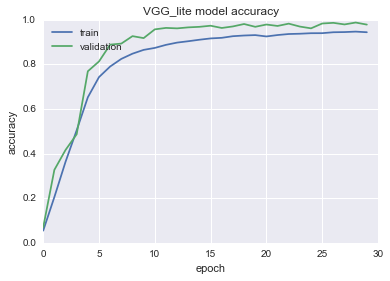

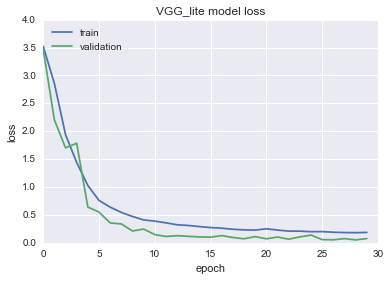

In [35]:
plot_history(history, name='VGG_lite')

In [57]:
## Re-run the saved model

# create a new instance of the model
saved_weights = 'VGG_lite1_19_23_59_weights-28-0.99.hdf5'
vgg_lite2 = create_vgg_lite()
# run the model with saved weights so far
history2 = run_model_augmentation(vgg_lite2, name='VGG_lite2', weights=saved_weights, nb_epochs=30)

Creating VGG-lite1 model...
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
conv0 (Convolution2D)            (None, 30, 30, 16)    448         convolution2d_input_3[0][0]      
____________________________________________________________________________________________________
conv1 (Convolution2D)            (None, 28, 28, 16)    2320        conv0[0][0]                      
____________________________________________________________________________________________________
maxpooling2d_5 (MaxPooling2D)    (None, 14, 14, 16)    0           conv1[0][0]                      
____________________________________________________________________________________________________
dropout_9 (Dropout)              (None, 14, 14, 16)    0           maxpooling2d_5[0][0]             
_______________________________________________________________

/Users/aa/Developer/miniconda/envs/py35/lib/python3.5/site-packages/keras/callbacks.py:267: RuntimeWarning: ModelCheckpoint mode <built-in function max> is unknown, fallback to auto mode.
  RuntimeWarning)


Starting training...
Epoch 1/30
Epoch 00000: val_acc improved from -inf to 0.98215, saving model to VGG_lite2_20_12_37_weights-00-0.98.hdf5
55s - loss: 0.1764 - acc: 0.9466 - top_k_categorical_accuracy: 0.9957 - val_loss: 0.0590 - val_acc: 0.9821 - val_top_k_categorical_accuracy: 0.9983
Epoch 2/30
Epoch 00001: val_acc improved from 0.98215 to 0.98457, saving model to VGG_lite2_20_12_37_weights-01-0.98.hdf5
54s - loss: 0.1760 - acc: 0.9486 - top_k_categorical_accuracy: 0.9957 - val_loss: 0.0509 - val_acc: 0.9846 - val_top_k_categorical_accuracy: 0.9995
Epoch 3/30
Epoch 00002: val_acc did not improve
54s - loss: 0.1666 - acc: 0.9499 - top_k_categorical_accuracy: 0.9967 - val_loss: 0.0534 - val_acc: 0.9844 - val_top_k_categorical_accuracy: 0.9989
Epoch 4/30
Epoch 00003: val_acc improved from 0.98457 to 0.98789, saving model to VGG_lite2_20_12_37_weights-03-0.99.hdf5
54s - loss: 0.1714 - acc: 0.9490 - top_k_categorical_accuracy: 0.9954 - val_loss: 0.0438 - val_acc: 0.9879 - val_top_k_categ

## Final Results

We are able to achieve **98.15% accuracy** on the Test dataset, which is quite good for such a simple architecture. Additionally, we are able to score **99.52% top_k_categorical_accuracy**

👍👍

Final weights are saved in `VGG_lite2_20_12_37_weights-15-0.99.hdf5`

**What Worked:**

- **Learning Rate Schedule:** Reducing the learning rate automatically helped. The LR was set to 0.01, and reduced automatically using the Stochastic Gradient Descent class. Additionally, Keras allows `ReduceLROnPlateau` callback that automatically further reduces LR based on specified params. 
- **Dropout:** Dropouts were used - varying from 30% to 50% after Maxpool and Dense layers. This helped greatly.

- **Fully Connected Layers:** Increasing the size of fully connected layers (from, say, 400 to 1024) as well as the number (from 2 to 3 FC layers) greatly increased the performance. 

**What Didn't Work:**

- ** L2 Regularization:** I tried L2 regularization with a few values; however, the effect of L2 wasn't meaningful for this architecture, hence it was left out for training.


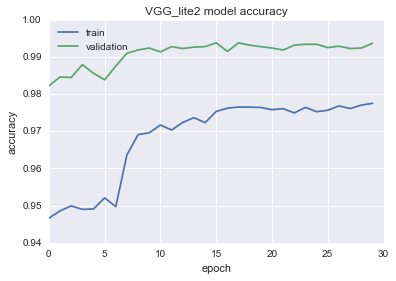

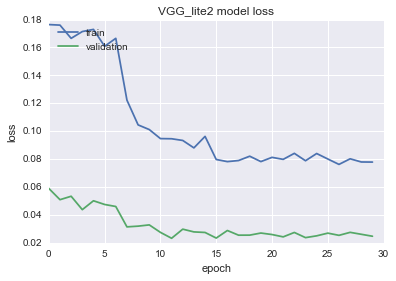

In [58]:
plot_history(history2, name='VGG_lite2')

_Note that in the charts just above, the epochs start at # 30, as the model was pre-trained for 30 epochs and then further trained for another 30, for a total of 60 epochs._

### Testing on Seen Images 

Below are a few tests on the Test Dataset, showing the Top5 predicted classes

In [34]:
def plot_top5(test_img, proba, y_true_classid):
    ''' Plot softmax visualization of the given test image and its softmax proba vector
    '''
    # get index of top5 probabilities, with max at the front
    top5_indices = np.argsort(proba)[::-1][:5]
    print()
    # print('   top5 indices:', top5_indices)
    # find top5 classes from Sign Names
    top5_classes = pd.DataFrame(sign_names.iloc[top5_indices])
    
    # drop unwanted cols
    del top5_classes['train_frequency']
    del top5_classes['test_frequency']

    # correct sign
    true_sign = sign_names.iloc[y_true_classid]
    print('-- True label: ClassId: {0} => {1}'
            .format(true_sign['ClassId'], true_sign['SignName']))
    
    print('   top 5 predictions --')
    top5_classes['prob'] = proba[top5_indices]
    # print(top5_classes)
    
    plt.figure(figsize=(5, 2))
    gs = gridspec.GridSpec(1, 2, width_ratios=[2,3])
    plt.subplot(gs[0])
    plt.imshow(test_img)
    plt.grid('off')
    plt.axis('off')
    plt.subplot(gs[1])
    plt.barh(6 - np.arange(5), top5_classes['prob'], align='center')
    i = 0 
    for tix in top5_indices:
        plt.text(top5_classes['prob'][tix]+0.03, # x
                 6-i-0.25,                       # y
                 top5_classes['SignName'][tix])  # label
        i += 1
    plt.axis('off')
    plt.show()

In [40]:
def do_predictions_on_test(model, X, y, n=8):
    ''' Do predictions on Test dataset
    '''
    # get list of n random images from X
    rand_ix = np.random.choice(len(X), n)
    # print('random indexes: ', rand_ix)
    x_rand = np.array([X[i] for i in rand_ix])
    # print('x_rand shape:', x_rand.shape)
    
    # list of correct classes for the above test images
    y_correct = np.array([y[i] for i in rand_ix])
    
    print('Doing class predictions on samples')
    pred_classes = model.predict_classes(x_rand, batch_size=n, verbose=0)
    # print(pred_classes.shape)
    print('  correct   classes: ', y_correct)
    print('  predicted classes: ', pred_classes)
    
    print('--------------------------------------------')
    print('Doing softmax proba predictions on n samples')
    proba = model.predict_proba(x_rand, batch_size=n, verbose=0)
    # print(proba.shape)
    # print(proba)

    for i in range(len(proba)):
        plot_top5(x_rand[i], proba[i], y_correct[i])
        
    

In [36]:
## run a sample of 5 images from test dataset - using the latest model
saved_weights = 'VGG_lite2_20_12_37_weights-15-0.99.hdf5'
vgg_test_model = create_vgg_lite()
save_load_model(vgg_test_model, name='test_vgg_lite', weights=saved_weights)


Creating VGG-lite1 model...
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
conv0 (Convolution2D)            (None, 30, 30, 16)    448         convolution2d_input_2[0][0]      
____________________________________________________________________________________________________
conv1 (Convolution2D)            (None, 28, 28, 16)    2320        conv0[0][0]                      
____________________________________________________________________________________________________
maxpooling2d_3 (MaxPooling2D)    (None, 14, 14, 16)    0           conv1[0][0]                      
____________________________________________________________________________________________________
dropout_5 (Dropout)              (None, 14, 14, 16)    0           maxpooling2d_3[0][0]             
_______________________________________________________________

Doing class predictions on samples
  correct   classes:  [41 25  4 20 25  1  4 11]
  predicted classes:  [41 25  4 20 25  1  4 11]
--------------------------------------------
Doing softmax proba predictions on n samples

-- True label: ClassId: 41 => End of no passing
   top 5 predictions --


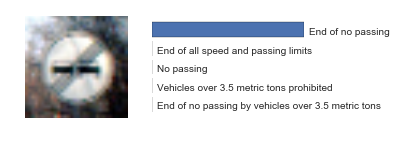


-- True label: ClassId: 25 => Road work
   top 5 predictions --


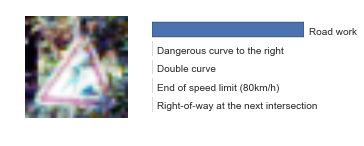


-- True label: ClassId: 4 => Speed limit (70km/h)
   top 5 predictions --


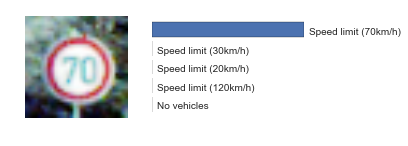


-- True label: ClassId: 20 => Dangerous curve to the right
   top 5 predictions --


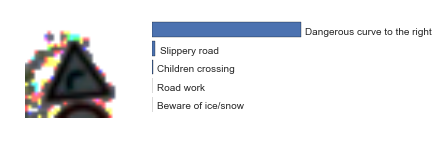


-- True label: ClassId: 25 => Road work
   top 5 predictions --


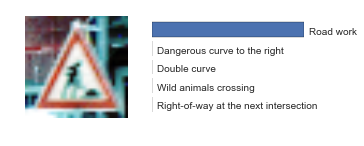


-- True label: ClassId: 1 => Speed limit (30km/h)
   top 5 predictions --


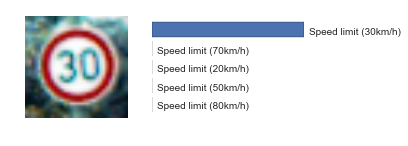


-- True label: ClassId: 4 => Speed limit (70km/h)
   top 5 predictions --


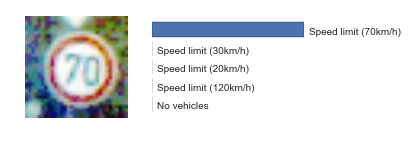


-- True label: ClassId: 11 => Right-of-way at the next intersection
   top 5 predictions --


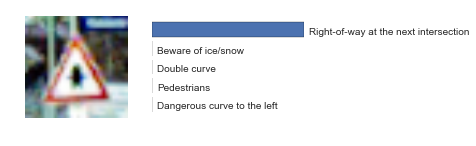

In [41]:
# run predictions on Test dataset
do_predictions_on_test(vgg_test_model, X_test_proc, y_test)

#### Discussion (Question 7 - on Test Images)

As can be seen above, the softmax probabilities are shown along with the Top 5 predicted classes for each test image. The model is **fairly certain** about its probabilities (which are very close to 1.0 or 0.0), which indicates that model has very low loss on predicted class. The test images are processed (normalized / equalized histogram) as with the training dataset. 

In [62]:
# create a new instance of the model
saved_weights = 'VGG_lite2_20_12_37_weights-15-0.99.hdf5'
vgg_test_model = create_vgg_lite()
save_load_model(vgg_test_model, name='test_vgg_lite', weights=saved_weights)

Creating VGG-lite1 model...
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
conv0 (Convolution2D)            (None, 30, 30, 16)    448         convolution2d_input_4[0][0]      
____________________________________________________________________________________________________
conv1 (Convolution2D)            (None, 28, 28, 16)    2320        conv0[0][0]                      
____________________________________________________________________________________________________
maxpooling2d_7 (MaxPooling2D)    (None, 14, 14, 16)    0           conv1[0][0]                      
____________________________________________________________________________________________________
dropout_13 (Dropout)             (None, 14, 14, 16)    0           maxpooling2d_7[0][0]             
_______________________________________________________________

## Test on Unseen Images (Questions 6, 7, 8)

I downloaded some 64 US and German road signs. 

The following tests on these US and German road signs show the results. As expected, signs that look like German road signs give better results than those that don't. 


In [42]:
import skimage.data
import skimage.transform

DATA_DIR = '/Users/aa/Developer/datasets/traffic-signs/german-signs'

def read_image(filename):
    # print('reading file: ', filename)
    image = cv2.imread(filename)
    image = cv2.resize(image,(32,32))
    image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
    return image

def read_image_skimage(name):
    # print('reading file:', name)
    image = skimage.data.imread(name)
    image = skimage.transform.resize(image, (32,32))
    return image

def load_images(datadir=DATA_DIR):
    ''' Load images from given directory '''
    images = []
    files = [os.path.join(datadir, f) 
             for f in os.listdir(datadir) if f.endswith('.jpg')]
    print('reading files: ', len(files))
    images = [read_image(f) for f in files]
    print('loaded images: ', len(images))
    return images

def plot_new_signs(nrows, ncols, images):
    
    plt.figure(figsize=(10,8))
    gs1 = gridspec.GridSpec(ncols,nrows)
    gs1.update(wspace=0.01, hspace=0.01) # set the spacing between axes.
    
    for i in range(nrows * ncols):
        ax1 = plt.subplot(gs1[i])
        ax1.set_aspect('equal')
        plt.imshow(images[i])
        plt.axis('off')
    plt.show()


In [43]:
new_signs = load_images()

reading files:  64
loaded images:  64


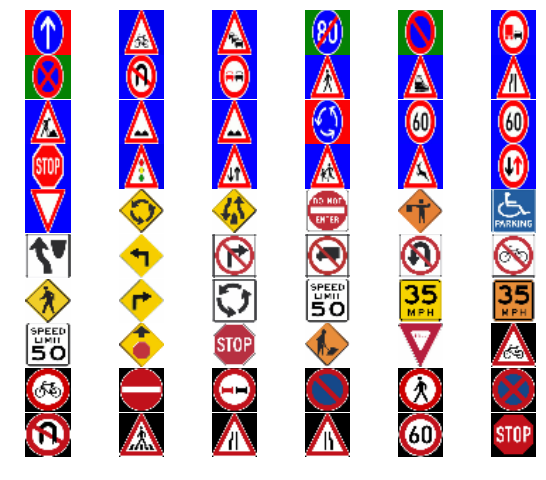

In [44]:
plot_new_signs(6, 10, new_signs)

In [45]:
# Equalize the new signs
new_signs_proc = np.array([eq_histogram_rescale(new_signs[i]) for i in range(len(new_signs))], dtype=np.float32)

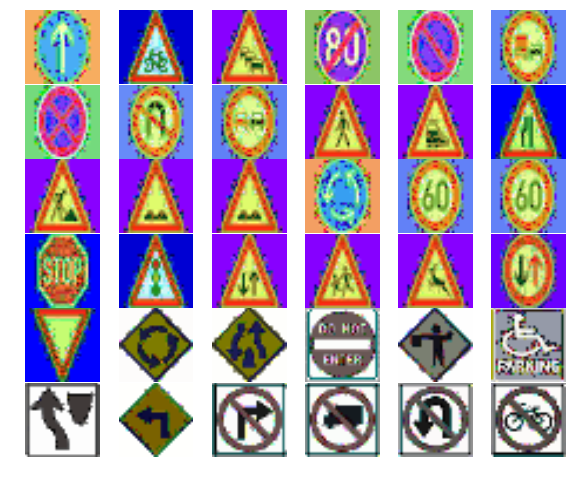

In [46]:
plot_new_signs(6, 6, new_signs_proc)

In [47]:
def plot_predicted_top5(image, proba):
    ''' Plot given test image, and visualize its softmax vector showing Top5 pred classes
    '''
    
    # get index of top5 probabilities, with max at the front
    top5_indices = np.argsort(proba)[::-1][:5]
    print()
    # print('top5 indices:', top5_indices)
    # find top5 classes from Sign Names
    top5_classes = pd.DataFrame(sign_names.iloc[top5_indices])
    
    # drop unwanted cols
    del top5_classes['train_frequency']
    del top5_classes['test_frequency']

    print('   top 5 predictions --')
    top5_classes['prob'] = proba[top5_indices]
    print(top5_classes)
    
    plt.figure(figsize=(5, 2))
    gs = gridspec.GridSpec(1, 2, width_ratios=[2,3])
    plt.subplot(gs[0])
    plt.imshow(image)
    plt.grid('off')
    plt.axis('off')
    plt.subplot(gs[1])
    plt.barh(6 - np.arange(5), top5_classes['prob'], align='center')
    i = 0 
    for tix in top5_indices:
        plt.text(top5_classes['prob'][tix]+0.03, # x
                 6-i-0.25,                       # y
                 top5_classes['SignName'][tix])  # label
        i += 1
    plt.axis('off')
    plt.show()
    
    

In [48]:
def predict_new_signs(model, X, n=5):
    ''' Predict new images from the given dataset X
    '''
    # get list of n random images from X
    rand_ix = np.random.choice(len(X), n)
    # print('random indexes: ', rand_ix)
    x_rand = np.array([X[i] for i in rand_ix])
    # print('x_rand shape:', x_rand.shape)
    
    print('Doing class predictions on samples')
    pred_classes = model.predict_classes(x_rand, batch_size=n, verbose=0)
    # print(pred_classes.shape)
    print('predicted classes: ', pred_classes)
    
    print('--------------------------------------------')
    print('Doing softmax proba predictions on n samples')
    proba = model.predict_proba(x_rand, batch_size=n, verbose=0)
    # print(proba.shape)
    # print(proba)

    for i in range(len(proba)):
        plot_predicted_top5(x_rand[i], proba[i])
        

### Predictions on Unseen Images (Question 7 - 8)

See the results below - for **Top5 Predicted Classes**, and **visualizations of softmax probabilities**.

Doing class predictions on samples
predicted classes:  [21 22 30 35 20  3 16 29 13 29]
--------------------------------------------
Doing softmax proba predictions on n samples

   top 5 predictions --
    ClassId                               SignName      prob
21       21                           Double curve  0.513391
11       11  Right-of-way at the next intersection  0.129171
31       31                  Wild animals crossing  0.117062
19       19            Dangerous curve to the left  0.061130
23       23                          Slippery road  0.059284


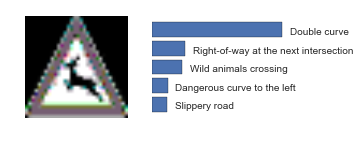


   top 5 predictions --
    ClassId               SignName      prob
22       22             Bumpy road  0.694160
26       26        Traffic signals  0.200585
31       31  Wild animals crossing  0.038705
18       18        General caution  0.030050
29       29      Bicycles crossing  0.029116


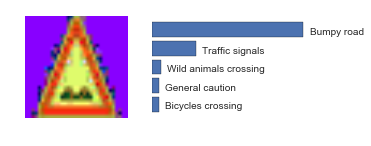


   top 5 predictions --
    ClassId                               SignName      prob
30       30                     Beware of ice/snow  0.615164
29       29                      Bicycles crossing  0.346643
28       28                      Children crossing  0.023637
11       11  Right-of-way at the next intersection  0.004136
3         3                   Speed limit (60km/h)  0.002561


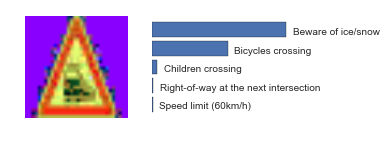


   top 5 predictions --
    ClassId                               SignName      prob
35       35                             Ahead only  0.957572
11       11  Right-of-way at the next intersection  0.018220
34       34                        Turn left ahead  0.009190
36       36                   Go straight or right  0.003552
27       27                            Pedestrians  0.002297


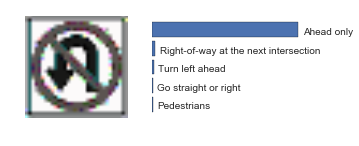


   top 5 predictions --
    ClassId                      SignName      prob
20       20  Dangerous curve to the right  0.195979
13       13                         Yield  0.123622
25       25                     Road work  0.094011
12       12                 Priority road  0.070511
26       26               Traffic signals  0.064175


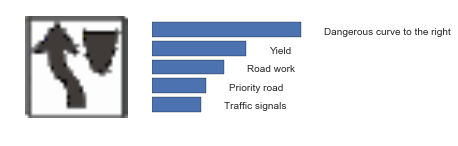


   top 5 predictions --
    ClassId              SignName      prob
3         3  Speed limit (60km/h)  0.849924
9         9            No passing  0.064186
2         2  Speed limit (50km/h)  0.049588
5         5  Speed limit (80km/h)  0.019168
15       15           No vehicles  0.008594


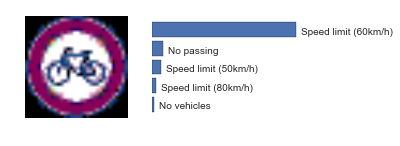


   top 5 predictions --
    ClassId                                           SignName      prob
16       16           Vehicles over 3.5 metric tons prohibited  0.979052
42       42  End of no passing by vehicles over 3.5 metric ...  0.016420
7         7                              Speed limit (100km/h)  0.001461
9         9                                         No passing  0.001170
5         5                               Speed limit (80km/h)  0.000658


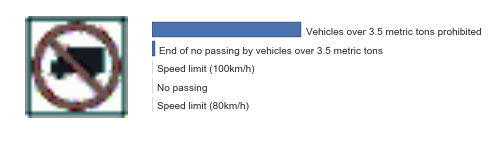


   top 5 predictions --
    ClassId               SignName      prob
29       29      Bicycles crossing  0.999025
28       28      Children crossing  0.000534
30       30     Beware of ice/snow  0.000259
22       22             Bumpy road  0.000112
31       31  Wild animals crossing  0.000045


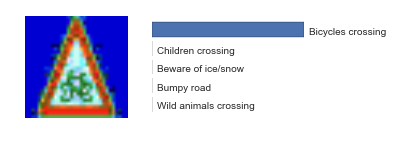


   top 5 predictions --
    ClassId              SignName      prob
13       13                 Yield  0.566238
15       15           No vehicles  0.163379
4         4  Speed limit (70km/h)  0.091114
5         5  Speed limit (80km/h)  0.061150
1         1  Speed limit (30km/h)  0.021747


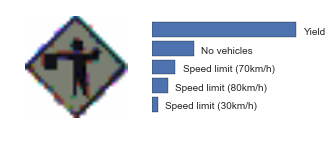


   top 5 predictions --
    ClassId            SignName      prob
29       29   Bicycles crossing  0.971831
28       28   Children crossing  0.019835
30       30  Beware of ice/snow  0.006234
22       22          Bumpy road  0.000698
23       23       Slippery road  0.000657


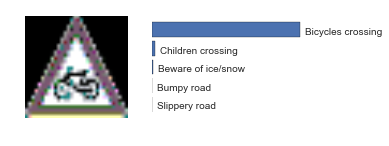

In [49]:
predict_new_signs(vgg_test_model, new_signs_proc, n=10)

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

There are various aspects to consider when thinking about this problem:

- Neural network architecture
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

**NOTE:** The LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) at the end of the CNN lesson is a solid starting point. You'll have to change the number of classes and possibly the preprocessing, but aside from that it's plug and play!

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [ ]:
### Preprocess the data here.
### Feel free to use as many code cells as needed.

### Question 1 

_Describe how you preprocessed the data. Why did you choose that technique?_

**Answer:**

_As mentioned above_, the images were preprocessed by using Keras framework's **ImageDataGenerator**. The images were:

- Histogram-Equalized using OpenCV
- Rotated, sheared, shifted (height/width). In this case, I rotated the images by +/- 15 degrees; and sheared and shifted by 10% (of height/width). Larger angles were not chosen as some signs need correct orientation.

This created a **"jittered image"** dataset that augmented the existing dataset, to better allow for the network to train.

These techniques were chosen because:
- these were shown to work in research papers (see LeCun et al)
- relatively easy to implement
- provide additional images for each class (as some classes had very few images (~200 only) for training)

In [ ]:
### Generate data additional data (OPTIONAL!)
### and split the data into training/validation/testing sets here.
### Feel free to use as many code cells as needed.

### Question 2

_Describe how you set up the training, validation and testing data for your model. **Optional**: If you generated additional data, how did you generate the data? Why did you generate the data? What are the differences in the new dataset (with generated data) from the original dataset?_

**Answer:**

_As shown above_, the Training dataset was further split into a 80% Training and 20% Validation dataset, using `train_test_split()`. 

The final train / validation / test breakdown was as follows:

[Number of Samples, Height, Width, Channels]

```
Training shape:(31367, 32, 32, 3)
Validatn shape:(7842, 32, 32, 3)
Testing  shape:(12630, 32, 32, 3)
```

In [ ]:
### Define your architecture here.
### Feel free to use as many code cells as needed.

### Question 3

_What does your final architecture look like? (Type of model, layers, sizes, connectivity, etc.)  For reference on how to build a deep neural network using TensorFlow, see [Deep Neural Network in TensorFlow
](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/b516a270-8600-4f93-a0a3-20dfeabe5da6/concepts/83a3a2a2-a9bd-4b7b-95b0-eb924ab14432) from the classroom._


**Answer:**

I  tested out a couple of architectures, starting with the simple **LeNet model** and then adding a couple more convNet layers to it. These gave results between **92% - 95% test accuracy.**

I tried out a deeper model, which did not yield very good results, perhaps due to size of training data. 

I finally settled on a _**VGG lite**_ style model, which is depicted below. As mentioned above, this model yielded **98.15% test accuracy** after training for ~60 epochs. 



In [ ]:
### Train your model here.
### Feel free to use as many code cells as needed.

### Question 4

_How did you train your model? (Type of optimizer, batch size, epochs, hyperparameters, etc.)_


**Answer:**

- **Optimizer**: Tested with **Adam** optimizer (which did not automatically reduce the Learning Rate). Finally settled with a regular **Stochastic Gradient Descent (SGD)** optimizer, with initial _Learning Rate_ of 0.01 that was decayed based on both on epochs, as well as on plateauing of val_loss performance. This last part was done automatically using Keras-provided **ReduceLROnPlateau** callback function. 

- **Epochs**: Initially tested several architectures on epochs from 10-20, for trial purposes. then finally settled on 50-60 epochs with the selected architecture.

- ** Batch Size**: Used batch sizes varying from 64 to 128. However, decided to keep the batch size at 64 finally, as I was training on my laptop only. 

- ** Learning Rate**: Used starting rate of 0.01, which was decayed automatically, and then additionally used `ReduceLROnPlateau` method. See detail here: https://keras.io/callbacks/

### Question 5


_What approach did you take in coming up with a solution to this problem? It may have been a process of trial and error, in which case, outline the steps you took to get to the final solution and why you chose those steps. Perhaps your solution involved an already well known implementation or architecture. In this case, discuss why you think this is suitable for the current problem._

**Answer:**

In this particular case, since I've used TensorFlow before, I decided to use Keras as it allowed quick testing of different architectures. 

I performed the model search manually instead of via a GridSearch, mainly because I wasn't sure which models I wanted to try out.

The following models were tested:
- LeNet
- Variations on LeNet (deeper filters, different sizes of filters, etc)
- Deepner networks, which 2-4 extra convnet layers

However, the performance started worsening a the model got more complex. 

Then, having read 1-2 papers, I decided to go with a simpler model architecture. I settled on a **VGG Lite style** model, as depicted above, which gave surprisingly good performance in 10-15 epochs. That's the one I finally chose.

![Model Architecture](AA-CNN-model-traffic-signs.jpg)

---

## Step 3: Test a Model on New Images

Take several pictures of traffic signs that you find on the web or around you (at least five), and run them through your classifier on your computer to produce example results. The classifier might not recognize some local signs but it could prove interesting nonetheless.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [ ]:
### Load the images and plot them here.
### Feel free to use as many code cells as needed.

### Question 6

_Choose five candidate images of traffic signs and provide them in the report. Are there any particular qualities of the image(s) that might make classification difficult? It could be helpful to plot the images in the notebook._



**Answer:**

I downloaded ~60 US and German Road Traffic signs. These are shown in the cells above. 

I ran histogram equalization on them, and ran them thru the model's predictor.

As expected, the signs/images that were seen before gave a very accurate result while some others that the model hadn't seen before didn't perform as well.


In [ ]:
### Run the predictions here.
### Feel free to use as many code cells as needed.

### Question 7

_Is your model able to perform equally well on captured pictures when compared to testing on the dataset? The simplest way to do this check the accuracy of the predictions. For example, if the model predicted 1 out of 5 signs correctly, it's 20% accurate._

_**NOTE:** You could check the accuracy manually by using `signnames.csv` (same directory). This file has a mapping from the class id (0-42) to the corresponding sign name. So, you could take the class id the model outputs, lookup the name in `signnames.csv` and see if it matches the sign from the image._


**Answer:**

The model performed reasonably well on the german signs, but not as well on US road signs.

For example, as shown in above cells, it correctly identified **Bumpy Road, Bike Crossing, No Vehicles over 3.5 Metric Tons** signs. For a few, the model identified in Top5 the correct signs, e.g **Wild Animals Crossing**.  However, it failed on some other signs (**Flagger (US sign), Train Crossing, No U-Turn**, etc.. It hilariously identified a No-Bicycles sign as a _Speed Limit 60_ sign. 

#### Prediction accuracy
 
While the model is nearly 100% accurate on the original German Test dataset, it is only ~50-60% accurate on the unseen images. This is somewhat expected, as the unseen images include US road signs, some of which are different from German road signs, and hence throw off predicting capabilities

#### Qualities of unseen images
It appears that some unseen images that have a **dark black** background did not perform well; this is likely because the image pre-processing failed in these cases, causing spurious predictions. Additionally, the unseen images have **high saturation**; when these were histogram-equalized, the dark black background turned into other colors (e.g. Purple), which likely threw off the network's predicting capabilities.


To make the model more robust, one would have to _perform more image preprocessing_ (which was somewhat basic in this case), e.g. including Contrast Normalization; and also _include a larger training dataset._

All the results are shown in cells above.

In [ ]:
### Visualize the softmax probabilities here.
### Feel free to use as many code cells as needed.

### Question 8

*Use the model's softmax probabilities to visualize the **certainty** of its predictions, [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. Which predictions is the model certain of? Uncertain? If the model was incorrect in its initial prediction, does the correct prediction appear in the top k? (k should be 5 at most)*

`tf.nn.top_k` will return the values and indices (class ids) of the top k predictions. So if k=3, for each sign, it'll return the 3 largest probabilities (out of a possible 43) and the correspoding class ids.

Take this numpy array as an example:

```
# (5, 6) array
a = np.array([[ 0.24879643,  0.07032244,  0.12641572,  0.34763842,  0.07893497,
         0.12789202],
       [ 0.28086119,  0.27569815,  0.08594638,  0.0178669 ,  0.18063401,
         0.15899337],
       [ 0.26076848,  0.23664738,  0.08020603,  0.07001922,  0.1134371 ,
         0.23892179],
       [ 0.11943333,  0.29198961,  0.02605103,  0.26234032,  0.1351348 ,
         0.16505091],
       [ 0.09561176,  0.34396535,  0.0643941 ,  0.16240774,  0.24206137,
         0.09155967]])
```

Running it through `sess.run(tf.nn.top_k(tf.constant(a), k=3))` produces:

```
TopKV2(values=array([[ 0.34763842,  0.24879643,  0.12789202],
       [ 0.28086119,  0.27569815,  0.18063401],
       [ 0.26076848,  0.23892179,  0.23664738],
       [ 0.29198961,  0.26234032,  0.16505091],
       [ 0.34396535,  0.24206137,  0.16240774]]), indices=array([[3, 0, 5],
       [0, 1, 4],
       [0, 5, 1],
       [1, 3, 5],
       [1, 4, 3]], dtype=int32))
```

Looking just at the first row we get `[ 0.34763842,  0.24879643,  0.12789202]`, you can confirm these are the 3 largest probabilities in `a`. You'll also notice `[3, 0, 5]` are the corresponding indices.

**Answer:**


The softmax probabilities of the predicted classes are also shown above with horizontal bar charts. 

One point I notice is that the model is _fairly certain_ (i.e. probabilities are very close to 0.99 or 1.0) for the predicted classes, even when the predicted classes are not correct; this might indicate certain level of overfitting. A larger dataset and/or different hyperparams might reduce the probabilities somewhat. This was not tested. 

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.